In [257]:
# Phu, Andrea and Watcher
# 2018 Spring
import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch import FloatTensor, LongTensor
import numpy as np
import pandas as pd
import time
import os
import pickle
import string
import torch.utils.data as data_utils
import psutil
from random import shuffle
from sklearn.utils import shuffle as skshuffle
import random
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
rand_state = 44
torch.manual_seed(rand_state)
random.seed(rand_state)
np.random.seed(rand_state)

## We first read in the data

In [2]:
processed_data_path = '/data/Dropbox/judge_embedding_data_sp18'
all_data_save_path = os.path.join(processed_data_path,"finalized_all_data","all_data_dict.pkl")
all_data_support_save_path = os.path.join(processed_data_path,"finalized_all_data","all_data_dict_support.pkl")
all_data_df_save_path = os.path.join(processed_data_path,"finalized_all_data","all_data_df.h5")
finished_embedding_folder_path = os.path.join(processed_data_path,'finished_judge_embedding')


In [3]:
all_data_dict = pickle.load(open(all_data_save_path,"rb"))
topic_glove_emb = all_data_dict['topic_glove_emb'][0]
judgeId2Index = all_data_dict['judge_id_to_index'][0]
judgeIndex2Id = all_data_dict['judge_index_to_id'][0]
all_data_df = all_data_dict['data_df']
all_data_df[:4]

,caseid,year,middle_part,opinion_text,songername,judgeidentificationnumber,topic,geniss,opinion_vector,judge_embed_index,Circuit,date,affirmdummy,judge_decision
0,XB0PMNQNB5G0,1891,contentMajOp,"[0, 202, 1268, 13, 0, 4600, 3, 0, 247954, 128,...","PARDEE, DON A.",1830.0,Civil Procedure,4.0,"[-0.07445931306292275, 0.05843820821632856, -0...",0,5,1891-12-07,0.0,0
1,XFL757,1891,contentMajOp,"[15, 116, 4, 9238, 7, 22547, 3, 4092, 1219, 0,...","BROWN, HENRY BILLINGS",284.0,Civil Procedure,4.0,"[-0.07101038203845275, 0.029874279749715626, -...",1,6,1891-10-06,0.0,0
2,XB0PMRQNB5G0,1891,contentMajOp,"[215, 6, 68193, 3527, 255, 9670, 5, 12375, 3, ...","PARDEE, DON A.",1830.0,Contracts,7.0,"[-0.059691082627907024, 0.10039284279069777, -...",0,5,1891-12-07,0.0,0
3,XFL7KI,1891,contentMajOp,"[5, 0, 935, 4951, 5, 8151, 0, 4490, 3, 0, 305,...","LOCKE, JAMES WILLIAM",1410.0,Civil Procedure,4.0,"[-0.13210430623456784, 0.12352108086419746, -0...",2,5,1891-11-27,0.0,0


In [4]:
# we now read in the judge bio data
judge_bio_path = os.path.join(processed_data_path,"JudgesBioReshaped_TOUSE.dta")
judge_bio_df = pd.read_stata(judge_bio_path)
pd.options.display.max_rows = 24
pd.options.display.max_columns = 999
judge_bio_df.head()

,songername,judgeidentificationnumber,Term,id,AppointmentDate,TerminationDate,courtname,courttype,abarating,AbaUpdate,SenateConfirmationdate,RecessAppointDate,birthday,birthmonth,birthyear,deathmonth,deathday,deathyear,JudgeAssignedCourt,judgelastname,judgefirstname,judgemiddlename,suffix,Circuitjudge,SeatState,retirementfromactiveservice,dateaschiefjudgebegin,presidentname,seconddateaschiefjudgebegin,senatevoicevote,senatevoteayesnays,Committeeactiondate,Degree1,Degree2,Degree3,Degree4,Degree5,degreeyear1,degreeyear2,degreeyear3,degreeyear4,degreeyear5,Committeeaction,ageon,vicelastnamepredecessor,vicefirstnamepredecessor,hearings,reportnumber,authorizationlegislation,placeofbirthcity,placeofbirthstate,placeofdeathcity,placeofdeathstate,deathdate,party_Updated,dateaschiefjudgeend,seconddateaschiefjudgeend,renominatingpresidentname,partyaffiliationofrenompres,referraldatejudicialcom,degree,degree_law,degree_other,district,nominationdatesenateexecutivej,genderNew,raceorethnicity,partyaffiliationofpresident,recessappointmentdate,committeeaction,committeeactiondate,senatevotedateconfirmationdate,commissiondate,dateoftermination,terminationspecificreason,nameofschool1,degree1,nameofschool2,degree2,nameofschool3,degree3,nameofschool4,degree4,nameofschool5,degree5,employmenttextfield,bankruptcyandmagistrateservice,Nominationdate,District_Circuit,party,pres,left,state,city,appres,aba,congresi,unityi,hdem,hrep,sdem,srep,hother,sother,x_dem,x_republican,x_instate_ba,x_elev,x_unity,x_aba,x_crossa,x_pfedjdge,x_pindreg1,x_plawprof,x_pscab,x_pcab,x_pusa,x_pssenate,x_paag,x_psp,x_pslc,x_pssc,x_pshouse,x_psg,x_psgo,x_psenate,x_psatty,x_pprivate,x_pmayor,x_plocct,x_phouse,x_pgov,x_pda,x_pcc,x_pccoun,x_pausa,x_pasatty,x_pag,x_pada,x_pgovt,x_llm_sjd,x_protestant,x_evangelical,x_mainline,x_noreligion,x_catholic,x_jewish,x_black,x_nonwhite,x_female,x_jd_public,x_ba_public,x_b10s,x_b20s,x_b30s,x_b40s,x_b50s,x_pbank,x_pmag,SchoolState1,Public1,Private1,SchoolState2,Public2,Private2,SchoolState3,Public3,Private3,SchoolState4,Public4,Private4,SchoolState5,Public5,Private5,TonotInclude,idtocorrrect,ayear,x_ageon40s,x_ageon50s,x_ageon60s,x_ageon40orless,x_ageon70ormore,pres_correct2,political_party,x_pago,startdate
0,"ABRAMS, RONNIE",3419,1,NaN,2012-03-23,NaT,"u. s. district court, southern district of new...",usdc,Qualified,,2012-03-22,NaT,NaN,NaN,1968.0,NaN,NaN,NaN,,ABRAMS,RONNIE,,,2,NY,,NaN,Barack Obama,NaN,No,96/2,2011-11-03,2.0,5.0,NaN,NaN,NaN,1990,1993,,,NaN,1.0,44.0,Kaplan,Lewis A.,10/04/2011,,,New York,NY,,,NaT,NaN,NaN,NaN,,,07/28/2011,,,,0208,07/28/2011,F,White,Democratic,,Reported With Recommendation,11/03/2011,03/22/2012,03/23/2012,,,Cornell University,B.A.,Yale Law School,J.D.,,,,,,,"Law clerk, Hon. Thomas P. Griesa, U.S. Distric...",,18836.0,,NaN,94.0,NaN,NaN,NaN,1.0,3.0,112TH,2.0,193.0,242.0,52,47,0.0,4.0,1.0,0.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NY,0.0,1.0,CT,0.0,1.0,,NaN,NaN,,NaN,NaN,,NaN,NaN,0.0,NaN,2012.0,1.0,0.0,0.0,0.0,0.0,NaN,,0.0,2012-03-23
1,"ABRUZZO, MATTHEW J.",1,1,2.0,1936-02-15,1971-05-28,"u. s. district court, eastern district of new ...",usdc,,,1936-02-12,NaT,30.0,4.0,1889.0,5.0,28.0,1971.0,Brooklyn,ABRUZZO,MATTHEW,T.,,2,NY,02/15/1966,NaN,Franklin D. Roosevelt,NaN,Yes,,1936-02-11,6.0,NaN,NaN,NaN,NaN,1910,,,,NaN,1.0,47.0,new,,,,49 Stat. 659,Brooklyn,NY,Potomac,MD,1971-05-28,1.0,NaN,NaN,,,02/03/1936,,,,0207,02/03/1936,M,White,Democratic,,Reported With Recommendation,02/11/1936,02/12/1936,02/15/1936,05/28/1971,Death,Brooklyn Law School,LL.B.,,,,,,,,,"Private practice, Brooklyn, New York, 1910-1936",,-8733.0,0207,1.0,14.0,3.0,32.0,3220.0,1.0,6.0,74TH,0.0,322.0,103.0,69,25,0.0,2.0,1.0,0.0,0.0,NaN,1.0,0.0,0.0,NaN,1.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

In [119]:
naive_judge_emb_path = os.path.join(finished_embedding_folder_path,"centered_naive_emb.pkl")
naive_judge_emb = pickle.load(open(naive_judge_emb_path,"rb"))

trained_judge_emb_path = os.path.join(finished_embedding_folder_path,"centered_trained_emb_May13.pkl")
trained_judge_emb = pickle.load(open(trained_judge_emb_path,"rb"))


In [120]:
naive_judge_emb.shape

(2099, 300)

In [121]:
trained_judge_emb.shape

(2099, 300)

In [73]:
judge_party_df = judge_bio_df[['judgeidentificationnumber', 'x_dem', 'x_republican']].copy()
all_judge_df = all_data_df[['songername', 'judgeidentificationnumber']].copy()
all_judge_df = all_judge_df.drop_duplicates()

In [74]:
def f_judgeID2Index(x):
    judgeId = int(x['judgeidentificationnumber'])
    Index = judgeId2Index[judgeId]
    return Index

In [126]:
all_judge_df['emb_Index'] = all_judge_df.apply(f_judgeID2Index, axis = 1)

all_judge_party_df = all_judge_df.merge(judge_party_df, on = 'judgeidentificationnumber', how = 'left')
all_judge_party_df = all_judge_party_df[all_judge_party_df['x_dem']+all_judge_party_df['x_republican'] == 1 ]
all_judge_party_df.drop_duplicates(inplace = True)

In [127]:
all_judge_party_df.head()

,songername,judgeidentificationnumber,emb_Index,x_dem,x_republican
0,"PARDEE, DON A.",1830,0,0.0,1.0
1,"BROWN, HENRY BILLINGS",284,1,0.0,1.0
3,"LOCKE, JAMES WILLIAM",1410,2,0.0,1.0
4,"NELSON, SUSAN RICHARD",3339,3,1.0,0.0
5,"BRUCE, JOHN",292,4,0.0,1.0


In [128]:
judge_party_count = all_judge_party_df.groupby('judgeidentificationnumber')['emb_Index'].count().reset_index()
unique_party_judge = judge_party_count[judge_party_count['emb_Index']==1]['judgeidentificationnumber']
all_judge_party_df = all_judge_party_df[all_judge_party_df['judgeidentificationnumber'].isin(unique_party_judge)]

## Prediction using naive judge embedding with Logistic Regression

In [176]:
naive_judge_emb_df = pd.DataFrame.from_dict(naive_judge_emb)
naive_judge_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.004302,-0.006339,-0.002392,0.004763,-0.002406,-0.000910,0.002726,-0.004876,-0.002380,0.039431,-0.005456,-0.001561,0.000290,0.002704,-0.004327,-0.001136,-0.000795,0.000580,0.005513,0.000902,0.002573,-0.011485,-0.000386,-0.006335,0.007360,-0.002113,0.000677,0.003459,0.003573,-0.004791,-0.003095,0.001350,0.007335,0.008629,0.001399,-0.008515,0.005469,-0.006010,-0.009477,-0.001690,0.001619,-0.001583,0.000649,0.007106,-0.000461,-0.014648,0.002509,0.002044,0.003353,-0.003185,0.002035,0.003173,-0.006329,-0.003628,-0.001392,-0.002830,-0.001860,-0.008012,-0.009590,-0.010135,0.001879,-0.002434,-0.007984,-0.002627,-0.000284,-0.004951,-0.005196,-0.006966,-0.000654,-0.010872,-0.002802,-0.004732,-0.005515,-0.004135,-0.001961,0.000075,-0.004344,-0.001827,0.005308,-0.004565,0.006561,-0.002663,-0.002129,0.002178,-0.005723,-0.006621,-0.000384,-0.005298,-0.001306,-0.004145,-0.001803,-0.000223,-0.000262,-0.001284,-0.007225,0.007261,0.002325,-0.003627,-0.000945,0.004657,-0.002589,-0.005926,0.002983,0.002653,-0.004263,-0.007658,-0.003033,0.000215,0.008015,-0.004822,0.002344,-0.000044,-0.000344,0.003510,-0.001797,-0.003242,0.002275,0.002968,-0.004710,0.006002,0.004410,0.006367,-0.002608,-0.018425,-0.001678,0.002160,-0.002135,-0.006021,0.005789,0.002283,-0.009041,-0.004478,-0.003152,0.002174,0.004109,-0.007586,-0.000396,0.000069,-0.003378,0.000629,0.001256,-0.004849,0.004997,0.005365,0.003956,0.003206,-0.003895,-0.001085,0.004965,-0.000118,0.011186,0.004383,0.000314,0.003656,-0.006464,0.001689,-0.002488,-0.006755,0.001401,-0.001768,-0.001716,0.001465,-0.000643,0.001030,-0.008239,0.002453,0.005692,-0.006382,-0.002199,0.001848,0.000721,0.008302,0.003424,0.004222,-0.000633,0.009730,0.008891,-0.002214,-0.004923,-0.001150,-0.001915,0.004697,-0.003467,-0.002596,-0.000750,-0.004673,-0.001829,-0.002520,-0.002946,-0.002745,0.002641,0.000703,-0.008636,0.003147,0.004974,0.007480,0.008019,0.000593,-0.004251,-0.004662,-0.011126,0.002446,0.002485,0.004873,-0.001531,-0.001204,-0.001170,0.000391,0.004894,-0.006629,-0.000183,0.002606,-0.011400,-0.001474,0.006652,0.002838,-0.002904,0.000667,-0.003163,-0.009662,-0.004223,-0.002314,0.002679,0.002812,-0.001702,-0.000150,-0.002558,-0.001414,0.003016,-0.003751,-0.002769,0.004242,0.000093,0.002784,0.005477,0.004865,0.000189,-0.001459,-0.001093,-0.000658,-0.008639,0.001516,0.000595,0.002827,0.017568,0.005703,-0.004065,-0.004358,0.001119,0.000960,0.000834,0.003594,0.003059,-0.000682,-0.001500,-0.000680,0.006293,0.001863,-0.001946,-0.003858,0.003524,-0.001309,0.000551,0.000676,0.004489,-0.005467,-0.000758,0.000554,-0.007005,-0.006980,-0.000125,-0.002558,-0.000864,-0.000042,-0.004726,0.000245,0.030294,0.004902,-0.003558,-0.001606,-0.003343,-0.004550,-0.000606,-0.001898,-0.001138,0.001032,0.003990,0.001707,-0.002005,-0.004360,0.005147,0.005398,0.000225,-0.006884,-0.005311,0.001901,0.002576,0.002121,0.003513,0.005195
1,0.010602,-0.000225,-0.006965,-0.023556

In [177]:
naive_judge_emb_final = naive_judge_emb_df.join(all_judge_party_df.set_index('emb_Index'), how='right').drop(['songername', 'judgeidentificationnumber', 'x_republican'], axis = 1)
naive_judge_emb_final.set_index(np.arange(0,naive_judge_emb_final.shape[0]), inplace = True)
naive_judge_emb_final.shape

(2051, 301)

In [307]:
X = naive_judge_emb_final.iloc[:,:300].values
y = naive_judge_emb_final['x_dem'].values
print(int(100*round(np.sum(naive_judge_emb_final['x_dem'])/naive_judge_emb_final.shape[0],2)),
      '% judges in the dataset are Democrats. The rest are Repulicans.')

46 % judges in the dataset are Democrats. The rest are Repulicans.


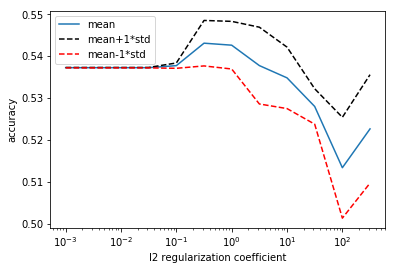

In [290]:
l2_reg = 10**np.arange(-3,3,0.5)
accuracy = []
for i in l2_reg:
    model = LR(C = i)
    cv_results = cross_validate(model, X, y, return_train_score=False)
    scores = cv_results['test_score']   
    accuracy.append({'l2_reg' : i, 'mean_accuracy': np.mean(scores), 'std' : np.std(scores)})

accuracy_df = pd.DataFrame.from_dict(accuracy)
plt.semilogx(accuracy_df['l2_reg'], accuracy_df['mean_accuracy'], label = 'mean')
plt.semilogx(accuracy_df['l2_reg'], accuracy_df['mean_accuracy'] + accuracy_df['std'], 'k--', label = 'mean+1*std')
plt.semilogx(accuracy_df['l2_reg'], accuracy_df['mean_accuracy'] - accuracy_df['std'], 'r--', label = 'mean-1*std')
plt.xlabel('l2 regularization coefficient')
plt.ylabel('accuracy')
plt.legend()

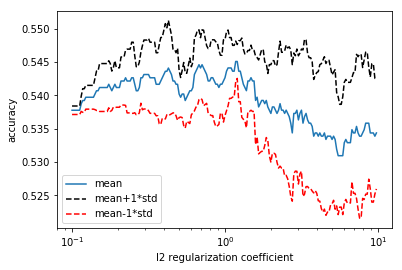

In [251]:
l2_reg = 10**np.arange(-1,1,0.01)
accuracy = []
for i in l2_reg:
    model = LR(C = i)
    cv_results = cross_validate(model, X, y, return_train_score=False)
    scores = cv_results['test_score']   
    accuracy.append({'l2_reg' : i, 'mean_accuracy': np.mean(scores), 'std' : np.std(scores)})

accuracy_df = pd.DataFrame.from_dict(accuracy)
plt.semilogx(accuracy_df['l2_reg'], accuracy_df['mean_accuracy'], label = 'mean')
plt.semilogx(accuracy_df['l2_reg'], accuracy_df['mean_accuracy'] + accuracy_df['std'], 'k--', label = 'mean+1*std')
plt.semilogx(accuracy_df['l2_reg'], accuracy_df['mean_accuracy'] - accuracy_df['std'], 'r--', label = 'mean-1*std')
plt.xlabel('l2 regularization coefficient')
plt.ylabel('accuracy')
plt.legend()

In [252]:
best_accuracy = np.max(accuracy_df['mean_accuracy'])
best_l2 = accuracy_df['l2_reg'][accuracy_df['mean_accuracy'].idxmax()]
print('Highest accuracy of ', best_accuracy, 'is achieved with l2 regularization = ', best_l2)

Highest accuracy of  0.545103361796568 is achieved with l2 regularization =  1.1748975549395322


## Prediction using naive judge embedding with Random Forest Classifier

In [308]:
model = RF(random_state = rand_state)
cv_results = cross_validate(model, X, y, return_train_score=False)
scores = cv_results['test_score']   
print(np.mean(scores), np.std(scores))

0.5143951295451226 0.009591242428599517


## Prediction using trained judge embedding with Logistic Regression

In [227]:
trained_judge_emb_df = pd.DataFrame.from_dict(trained_judge_emb)
trained_judge_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.159396,0.071692,-0.215653,-0.024703,0.170794,-0.079870,-0.077541,-0.002013,0.218121,0.255571,-0.497753,-0.525591,-0.026808,-0.012232,0.189906,0.102384,-0.061475,0.058565,-0.037409,-0.358610,0.212693,0.010505,0.092942,-0.075589,-0.166082,-0.445668,-0.072192,-0.362535,-0.040860,-0.082051,-0.328018,-0.132025,-0.023440,0.062417,-0.072720,-0.203381,-0.487597,-0.698282,-0.481864,-0.457692,-0.051794,-0.085687,-0.230828,-0.042899,-0.133110,-0.126286,-0.159278,-0.241009,-0.177944,0.138891,0.012915,-0.492126,-0.316107,0.081799,-0.815758,-0.076256,-0.293415,-0.100934,-0.034545,-0.295029,-0.112402,-0.167678,-0.299241,0.027995,-0.213176,0.091794,0.166994,-0.173572,-0.300352,-0.211719,-0.075178,0.156899,-0.066605,-0.114880,-0.072468,0.049398,-0.260819,-1.072322,-0.141765,-0.002298,0.174369,-0.135070,-0.055104,-0.103784,-0.098627,0.044433,0.080169,0.022395,-0.002554,0.046149,-0.027704,-0.063289,-0.202369,-0.404154,-0.015842,-0.137857,-0.277061,-0.043630,0.022229,0.021066,-0.296746,0.133421,-0.077214,-0.069913,0.017445,0.041098,-0.072312,-0.571634,-0.027720,-0.162921,-0.018724,-0.471537,-0.045462,-0.019920,0.145618,-0.120843,0.080933,-0.087304,0.109403,0.061665,-0.209621,-0.189511,-0.115827,0.061096,0.083099,0.002206,-0.090856,-0.027555,-0.320047,-0.137132,-0.007358,-0.370870,0.028432,-0.445135,0.105537,0.126010,-0.029120,-0.239994,-0.100367,-0.225766,-0.106179,-0.282210,-0.001421,-0.201124,-0.451656,-0.073947,0.098064,-0.126413,0.158749,0.095844,-0.016081,-0.089913,-0.168300,-0.154309,-0.052886,-0.381308,-0.139187,-0.265958,-0.039223,0.228168,0.060359,-0.219904,0.016732,0.010675,-0.069116,0.091343,-0.085967,-0.261204,-0.333353,-0.068173,0.204982,-0.142417,-0.806274,-0.077472,-0.024241,0.033003,-0.069484,-0.086854,-0.087513,-0.005759,0.047634,-0.169887,0.129390,-0.115367,-0.110986,-0.104697,-0.116198,0.113675,-0.918482,0.039167,-0.114442,0.019971,0.059537,-0.140106,0.105076,-0.104907,-0.105513,0.195310,-0.055351,-0.403341,-0.299588,-0.975369,0.269419,-0.032784,-0.514189,0.018088,-0.295967,-0.191416,0.137506,-0.490982,-0.170420,0.095348,0.055470,-0.027137,0.057419,-0.332782,-0.600626,-0.641774,-0.009127,-0.629493,-0.144817,-0.091403,-0.044493,-0.065886,-0.036845,-0.132514,0.008767,-0.076701,-0.337937,-0.300866,0.052945,0.130598,-0.047783,-0.775795,-0.079578,0.062389,0.093137,-0.198537,-0.660196,-0.275700,-0.124167,-0.265861,-0.234273,-0.125040,-0.092736,0.231579,-0.035437,0.141492,-0.123289,-0.233041,-0.557966,-0.181686,0.082492,-0.112374,-0.608705,-0.036913,-0.240272,-0.099075,-0.039572,-0.014345,0.129669,0.136259,0.005883,-0.152690,-0.165387,-0.299034,0.095917,-0.194790,-0.090728,0.176169,-0.462816,-0.067830,-0.237133,-0.079675,0.193584,-0.529462,0.107325,-0.095979,-0.138638,-0.281203,0.119624,-0.305184,0.049314,-0.188877,0.172122,-0.200329,-0.200812,-0.068955,-0.394012,-0.941687,-0.280044,0.107667,-0.576533,0.003966,-0.282895,0.086182,0.086339,0.016774,0.043473,-0.3

In [297]:
trained_judge_emb_final = trained_judge_emb_df.join(all_judge_party_df.set_index('emb_Index'), how='right').drop(['songername', 'judgeidentificationnumber', 'x_republican'], axis = 1)
trained_judge_emb_final.set_index(np.arange(0,naive_judge_emb_final.shape[0]), inplace = True)
trained_judge_emb_final.shape

(2051, 301)

In [310]:
X = trained_judge_emb_final.iloc[:,:300].values
y = trained_judge_emb_final['x_dem'].values
print(int(100*round(np.sum(naive_judge_emb_final['x_dem'])/naive_judge_emb_final.shape[0],2)),
      '% judges in the dataset are Democrats. The rest are Repulicans.')

46 % judges in the dataset are Democrats. The rest are Repulicans.


### tune l2 regularization parameter using cross validation

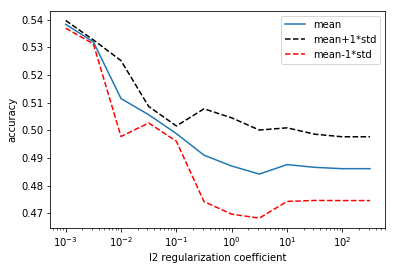

In [300]:
l2_reg = 10**np.arange(-3,3,0.5)
accuracy = []
for i in l2_reg:
    model = LR(C = i)
    cv_results = cross_validate(model, X, y, return_train_score=False)
    scores = cv_results['test_score']   
    accuracy.append({'l2_reg' : i, 'mean_accuracy': np.mean(scores), 'std' : np.std(scores)})

accuracy_df = pd.DataFrame.from_dict(accuracy)
plt.semilogx(accuracy_df['l2_reg'], accuracy_df['mean_accuracy'], label = 'mean')
plt.semilogx(accuracy_df['l2_reg'], accuracy_df['mean_accuracy'] + accuracy_df['std'], 'k--', label = 'mean+1*std')
plt.semilogx(accuracy_df['l2_reg'], accuracy_df['mean_accuracy'] - accuracy_df['std'], 'r--', label = 'mean-1*std')
plt.xlabel('l2 regularization coefficient')
plt.ylabel('accuracy')
plt.legend()

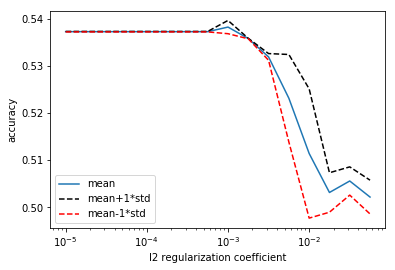

In [301]:
l2_reg = 10**np.arange(-5,-1,0.25)
accuracy = []
for i in l2_reg:
    model = LR(C = i)
    cv_results = cross_validate(model, X, y, return_train_score=False)
    scores = cv_results['test_score']   
    accuracy.append({'l2_reg' : i, 'mean_accuracy': np.mean(scores), 'std' : np.std(scores)})

accuracy_df = pd.DataFrame.from_dict(accuracy)
plt.semilogx(accuracy_df['l2_reg'], accuracy_df['mean_accuracy'], label = 'mean')
plt.semilogx(accuracy_df['l2_reg'], accuracy_df['mean_accuracy'] + accuracy_df['std'], 'k--', label = 'mean+1*std')
plt.semilogx(accuracy_df['l2_reg'], accuracy_df['mean_accuracy'] - accuracy_df['std'], 'r--', label = 'mean-1*std')
plt.xlabel('l2 regularization coefficient')
plt.ylabel('accuracy')
plt.legend()

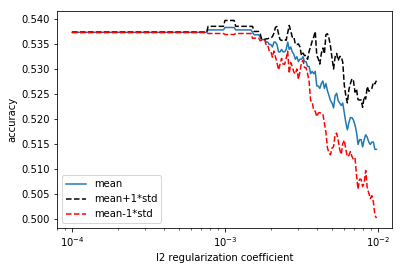

In [303]:
l2_reg = 10**np.arange(-4,-2,0.01)
accuracy = []
for i in l2_reg:
    model = LR(C = i)
    cv_results = cross_validate(model, X, y, return_train_score=False)
    scores = cv_results['test_score']   
    accuracy.append({'l2_reg' : i, 'mean_accuracy': np.mean(scores), 'std' : np.std(scores)})

accuracy_df = pd.DataFrame.from_dict(accuracy)
plt.semilogx(accuracy_df['l2_reg'], accuracy_df['mean_accuracy'], label = 'mean')
plt.semilogx(accuracy_df['l2_reg'], accuracy_df['mean_accuracy'] + accuracy_df['std'], 'k--', label = 'mean+1*std')
plt.semilogx(accuracy_df['l2_reg'], accuracy_df['mean_accuracy'] - accuracy_df['std'], 'r--', label = 'mean-1*std')
plt.xlabel('l2 regularization coefficient')
plt.ylabel('accuracy')
plt.legend()

In [305]:
best_accuracy = np.max(accuracy_df['mean_accuracy'])
best_l2 = accuracy_df['l2_reg'][accuracy_df['mean_accuracy'].idxmax()]
print('Highest accuracy of ', best_accuracy, 'is achieved with l2 regularization = ', best_l2)

Highest accuracy of  0.5382750353563961 is achieved with l2 regularization =  0.000999999999999951


## Prediction using trained judge embedding with Random Forest Classifier

In [311]:
model = RF(random_state = rand_state)
cv_results = cross_validate(model, X, y, return_train_score=False)
scores = cv_results['test_score']   
print(np.mean(scores), np.std(scores))

0.5075468539041655 0.012195184762836587
